In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time
import json
from urllib.parse import urlparse
from pathlib import Path
import re
from collections import defaultdict

# Monte Carlo Weights
To calculate the weights it's necessary to get the production rate for each file.
I commented out the functions to create the csv since I already got the needed csv

In [2]:
def extract_table(url):

    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, "html.parser")
    
    table = soup.find("table")  # the big summary table
    return table

url = "https://ild.ngt.ndu.ac.jp/mc-prod/prodmon/prodsum-mc2020.html"

# Since I already created the csv
#table = extract_table(url)

Here I extraced the the table from the site with the relevant columns

In [3]:
rows = []
current_rate = None

pattern = r'(\d+)\s*/\s*(\d+)'

def create_csv():
    for tr in table.find_all("tr"):
        text = tr.get_text(strip=True)
        # Detect section header with produced rate
        if ":" in text and "Produced rate" in text:
            # e.g., "higgs_inclusive : Produced rate 99.96% (…)"
            parts = text.split(":")
            current_rate = parts[1].strip().split()[2]
    
            matches = re.findall(pattern, parts[1].strip())
    
            # If you expect only one occurrence, you can take the first match:
            if matches:
                prod, gen = matches[0]          # strings representing the numbers
                prod_val = int(prod)            # convert to integers if needed
                gen_val  = int(gen)
    
                print(f"{current_rate}")
                print(f"N_Prod = {prod_val}")
                print(f"N_Gen  = {gen_val}")
            else:
                print("No number pair found.")
        elif tr.find_all("td"):
            tds = [td.get_text(strip=True) for td in tr.find_all("td")]
            # Build row with current_rate
            rows.append([current_rate,prod_val,gen_val] + tds)
    
    
    # Write CSV
    with open("250-SetA-with-rate.csv","w",newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ProducedRate","n_prod","n_gen","pol","processID","NbEvents","int.lumi",
                         "Done%","ElogID","ProdIDs"])
        writer.writerows(rows)

#create_csv()

In [4]:
# Option 2 – expand a tilde‑prefixed path
csv_path = os.path.expanduser("~/Documents/mestrado/code/tomaz-example/data/mc_tree/250-SetA-with-rate.csv")

# Load the CSV
df = pd.read_csv(csv_path)
df.head()

,ProducedRate,n_prod,n_gen,process_type,pol,processID,NbEvents,int.lumi(1/fb),Done %,ElogID(s),ProdIDs of DST and REC files
0,99.96%,6997400,7000000,e1e1h,eL.pL,402013,500000,801943,100.0,348,"DST=15095,15096;REC=15095"
1,99.96%,6997400,7000000,e1e1h,eL.pR,402001,500000,28294,100.0,347,"DST=15089,15090;REC=15089"
2,99.96%,6997400,7000000,e1e1h,eR.pL,402002,500000,44887,100.0,347,"DST=15089,15090;REC=15089"
3,99.96%,6997400,7000000,e1e1h,eR.pR,402014,498800,800018,99.8,348,"DST=15095,15096;REC=15095"
4,99.96%,6997400,7000000,e2e2h,eL.pR,402003,500000,29462,100.0,347,"DST=15089,15090;REC=15089"


The table above only have values for the integrated luminosity. The values for the cross-section are located at "https://ild.ngt.ndu.ac.jp/elog/genmeta/".

In [5]:
# ----------------------------------------------------------------
# 1) Configuration
# ----------------------------------------------------------------

BASE_URL = "https://ild.ngt.ndu.ac.jp/elog/genmeta/"
CSV_FILE = "cross_sections_250GeV.csv"

# ID range to scan (inclusive)
START_ID = 3897
END_ID   = 718

# ----------------------------------------------------------------
# 2) Ensure CSV has a header if it doesn't exist
# ----------------------------------------------------------------
try:
    with open(CSV_FILE, "r") as f:
        existing = True
except FileNotFoundError:
    existing = False

if not existing:
    with open(CSV_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "process_id", "dataset_label",
            "xsect_pb", "xsect_error_pb",
            "int_lumi_fb", "energy_GeV", "source_url"
        ])

# ----------------------------------------------------------------
# 3) Scraping loop
# ----------------------------------------------------------------
def safe_get(url):
    try:
        resp = requests.get(url, timeout=15)
        if resp.status_code == 200:
            return resp.text
    except requests.RequestException as e:
        print(f"  ❌ Failed to fetch {url}: {e}")
    return None

def extract_hidden(soup, name):
    tag = soup.find("input", {"name": name})
    return tag["value"] if tag and "value" in tag.attrs else None

def extract_process_id(raw_val):
    if raw_val:
        inner_text = BeautifulSoup(raw_val, "html.parser").get_text().strip()
        # Extract first number we find
        for part in inner_text.split():
            if part.isdigit():
                return part
    return None

def extract_xsect():
    for i in range(START_ID, END_ID - 1, -1):
        url = f"{BASE_URL}{i}"
        print(f"Processing {url}")
    
        html = safe_get(url)
        if not html:
            print("  Skipped (no content)")
            continue
    
        soup = BeautifulSoup(html, "html.parser")
    
        # Must check energy first
        energy = extract_hidden(soup, "Energy")
        if energy is None or energy.strip() != "250":
            print("  Skipped (Energy != 250)")
            continue
    
        # Extract fields
        raw_pid     = extract_hidden(soup, "process_id")
        process_id  = extract_process_id(raw_pid)
    
        xsect       = extract_hidden(soup, "xsect")
        xsect_err   = extract_hidden(soup, "xsect_error")
        intlumi     = extract_hidden(soup, "IntLumi")
    
        # Must have at least cross section & IntLumi
        if xsect is None or intlumi is None:
            print("  Skipped (missing xsect/IntLumi)")
            continue
    
        try:
            xsect_pb  = float(xsect)
        except ValueError:
            xsect_pb  = None
    
        try:
            xsect_err_pb = float(xsect_err) if xsect_err else None
        except ValueError:
            xsect_err_pb = None
    
        try:
            int_lumi_fb = float(intlumi)
        except ValueError:
            int_lumi_fb = None
    
        dataset_label = process_id if process_id else urlparse(url).path.split("/")[-1]
    
        # Append to CSV
        with open(CSV_FILE, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                process_id,
                dataset_label,
                xsect_pb,
                xsect_err_pb,
                int_lumi_fb,
                energy,
                url
            ])
    
        print(f"  ✔ Added: pid={process_id}, xsect={xsect_pb}, IntLumi={int_lumi_fb}")
    
        # Be gentle on the server
        time.sleep(0.3)

    print("\nDone scanning all IDs.")
    print(f"Updated CSV: {CSV_FILE}")

#extract_xsect()

Now I merge the old csv with the new one with process_id as the primary key

In [6]:
def merge_csv():
    # ------------------------------------------------------------------
    # 1️⃣ Load the CSVs
    # ------------------------------------------------------------------
    # Replace these paths with the actual locations of your files
    df_a = pd.read_csv("250-SetA-with-rate.csv")   # contains column named "processID"
    df_b = pd.read_csv("cross_sections_250GeV.csv")   # contains column named "process_id"
    
    # ------------------------------------------------------------------
    # 2️⃣ Align the key column names
    # ------------------------------------------------------------------
    # We'll standardise everything to "process_id"
    df_a = df_a.rename(columns={"processID": "process_id"})   # rename in df_a
    # df_b already uses "process_id", so no change needed there
    
    # ------------------------------------------------------------------
    # 3️⃣ Merge / combine the data
    # ------------------------------------------------------------------
    # Choose the join type you need:
    #   - "inner": keep only rows where the key exists in BOTH files
    #   - "left": keep all rows from df_a and attach matching rows from df_b
    #   - "right": keep all rows from df_b and attach matching rows from df_a
    #   - "outer": keep every row from both sides (fills missing values with NaN)
    merged = pd.merge(
        left=df_a,
        right=df_b,
        on="process_id",
        how="inner",          # ← change to left/right/outer if desired
        suffixes=("_a", "_b") # helps differentiate duplicate column names
    )
    
    # ------------------------------------------------------------------
    # 4️⃣ Drop columns you don’t need
    # ------------------------------------------------------------------
    # Example: suppose you only care about these three columns
    cols_to_keep = ["process_id"]
    cleaned = merged[cols_to_keep]
    
    # If you have a longer list of columns to discard instead:
    # cols_to_drop = ["unnecessary_col1", "temp_flag", "debug_info"]
    # cleaned = merged.drop(columns=cols_to_drop)
    
    # ------------------------------------------------------------------
    # 5️⃣ Save the result (optional)
    # ------------------------------------------------------------------
    merged.to_csv("combined_cleaned.csv", index=False)
    
    print("✅ Merge complete! Output saved to 'combined_cleaned.csv'")

#merge_csv()

Since only eL.pR polarization is needed. Let's filter the dataframe to only list the correct polarizations.

In [7]:
df = pd.read_csv("combined_cleaned.csv")
# Calculate the weight for each event
df["event_weight"] = (df["xsect_pb"] * df["int_lumi_fb"]) / df["NbEvents"]

filtered_df = df[df["pol"]=="eL.pR"].copy()
filtered_df.reset_index(drop=True,inplace=True)
filtered_df.head()

,ProducedRate,n_prod,n_gen,process_type,pol,process_id,NbEvents,int.lumi(1/fb),Done %,ElogID(s),ProdIDs of DST and REC files,xsect_pb,xsect_error_pb,int_lumi_fb,energy_GeV,source_url,event_weight
0,99.96%,6997400,7000000,e1e1h,eL.pR,402001,500000,28294,100.0,347,"DST=15089,15090;REC=15089",17.671491,0.0228,28294.16040,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3410,1.000000
1,99.96%,6997400,7000000,e2e2h,eL.pR,402003,500000,29462,100.0,347,"DST=15089,15090;REC=15089",16.970655,0.0138,29462.62240,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3413,1.000000
2,99.96%,6997400,7000000,e3e3h,eL.pR,402005,500000,29514,100.0,347,"DST=15089,15090;REC=15089",16.940726,0.0206,29514.67370,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3415,1.000000
3,99.96%,6997400,7000000,n1n1h,eL.pR,402007,499600,8278,99.9,347,"DST=15089,15090;REC=15089",60.350892,0.0620,8284.88169,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3417,1.000801
4,99.96%,6997400,7000000,n23n23h,eL.pR,402009,500000,7450,100.0,348,"DST=15095,15096;REC=15095",67.110727,0.0634,7450.37377,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3419,1.000000


📌 Important details
📍 Cross-section units

ELOG logs usually report 
𝜎
σ in pb (picobarns).

Integrated luminosity from the ILD summary is in fb⁻¹ (femtobarns⁻¹).
To combine:

So multiply cross section by 1000 before weighting.

## $w_{i} =\frac{\sigma_{i} \cdot \mathcal{L}_\text{target}}{N_\text{gen}}$

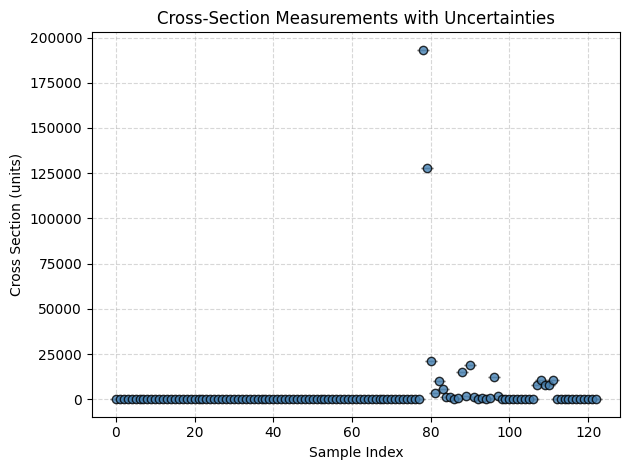

In [8]:
pids  = filtered_df["int.lumi(1/fb)"]
xsecs = filtered_df["xsect_pb"]
errs  = filtered_df["xsect_error_pb"]

# errorbar() draws points with vertical error bars
plt.errorbar(filtered_df.index,
             xsecs,
             yerr=errs,
             fmt='o',                 # marker style
             ecolor='gray',           # colour of the error bars
             capsize=4,               # little caps on the ends
             markersize=6,
             markerfacecolor='steelblue',
             markeredgecolor='k',
             alpha=0.8)

# -------------------------------------------------
# 4️⃣  Labels, title, optional styling
# -------------------------------------------------
plt.title('Cross‑Section Measurements with Uncertainties')
plt.xlabel('Sample Index')
plt.ylabel('Cross Section (units)')   # replace “units” with the proper unit, e.g., barns
plt.grid(True, linestyle='--', alpha=0.5)

# -------------------------------------------------
# 5️⃣  Show / save the figure
# -------------------------------------------------
plt.tight_layout()
plt.savefig('cross_section_errorbars.png', dpi=300)   # optional output file
plt.show()

After building the csv and calculating the weight of the events. Filtering the csv table to only have muon producing events

In [9]:
sigma_ZH = 346.0          # fb (example: eL pR)
BR_H_inv = 0.001
BR_Z_mumu = 0.03366
err_BR_Z_mumu = 0.00060
lumi = 250.0             # fb^-1
N_gen = 1_000_000

sigma_signal = sigma_ZH * BR_H_inv * BR_Z_mumu
weight_signal = sigma_signal * lumi / N_gen

# Center-of-Mass Energy
sqrt_s = 250.0

signal_row = {"process_id": "signal", "process_type": "signal","pol": "eL.pR", "xsect_pb": sigma_signal, "xsect_error_pb": 0.0}

In [10]:
# Define patterns that correspond to muon final states:
# Here we assume 'e2e2h' refers to muon pair events from the Z in ZH.
muon_patterns = ["e2e2h", "e2e2h", "mu", "muon", "mumu"]

# Filter
muon_mask = filtered_df['process_type'].str.contains("e2e2h", case=False, na=False) \
             | filtered_df['pol'].str.contains("e2e2h", case=False, na=False)


muon_events = filtered_df[muon_mask].copy()
muon_events.loc[len(muon_events)] = signal_row
muon_events = muon_events[muon_events["pol"] == "eL.pR"].sort_values("xsect_pb", ascending=False)
muon_events.reset_index(drop=True,inplace=True)

print(f"Found {len(muon_events)} muon-producing events")

# Optional: save to a separate file
muon_events.to_csv("muon_producing_events.csv", index=False)

Found 14 muon-producing events


In [11]:
muon_events

,ProducedRate,n_prod,n_gen,process_type,pol,process_id,NbEvents,int.lumi(1/fb),Done %,ElogID(s),ProdIDs of DST and REC files,xsect_pb,xsect_error_pb,int_lumi_fb,energy_GeV,source_url,event_weight
0,99.96%,6997400.0,7000000.0,e2e2h,eL.pR,402003,500000.0,29462.0,100.0,347,"DST=15089,15090;REC=15089",16.970655,1.380000e-02,2.946262e+04,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3413,1.0
1,100.00%,33598600.0,33600000.0,e2e2h_bb,eL.pR,402137,100000.0,10124.0,100.0,385,"DST=15206,15207;REC=15206",9.876921,8.031600e-03,1.012461e+04,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3503,1.0
2,100.00%,33598600.0,33600000.0,e2e2h_ww,eL.pR,402140,500000.0,137675.0,100.0,385,"DST=15206,15207;REC=15206",3.631720,2.953200e-03,1.376758e+05,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3513,1.0
3,100.00%,33598600.0,33600000.0,e2e2h_gg,eL.pR,402139,100000.0,71947.0,100.0,385,"DST=15206,15207;REC=15206",1.389897,1.130220e-03,7.194780e+04,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3511,1.0
4,100.00%,33598600.0,33600000.0,e2e2h_e3e3,eL.pR,402144,500000.0,469898.0,100.0,385,"DST=15206,15207;REC=15206",1.064060,8.652600e-04,4.698983e+05,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3509,1.0
5,100.00%,33598600.0,33600000.0,e2e2h_cc,eL.pR,402138,100000.0,203893.0,100.0,385,"DST=15206,15207;REC=15206",0.490452,3.988200e-04,2.038936e+05,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3505,1.0
6,100.00%,33598600.0,33600000.0,e2e2h_zz,eL.pR,402141,500000.0,1124527.0,100.0,385,"DST=15206,15207;REC=15206",0.444631,3.615600e-04,1.124528e+06,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3515,1.0
7,100.00%,33598600.0,33600000.0,e2e2h_aa,eL.pR,402142,100000.0,2595825.0,100.0,385,"DST=15206,15207;REC=15206",0.038523,3.132600e-05,2.595826e+06,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3499,1.0
8,100.00%,33598600.0,33600000.0,e2e2h_az,eL.pR,402143,100000.0,3851323.0,100.0,385,"DST=15206,15207;REC=15206",0.025965,2.111400e-05,3.851323e+06,250.0,https://ild.ngt.ndu.ac.jp/elog/genmeta/3501,1.0
9,NaN,NaN,NaN,signal,eL.pR,signal,NaN,NaN,NaN,NaN,NaN,0.011646,0.000000e+00,NaN,NaN,NaN,NaN


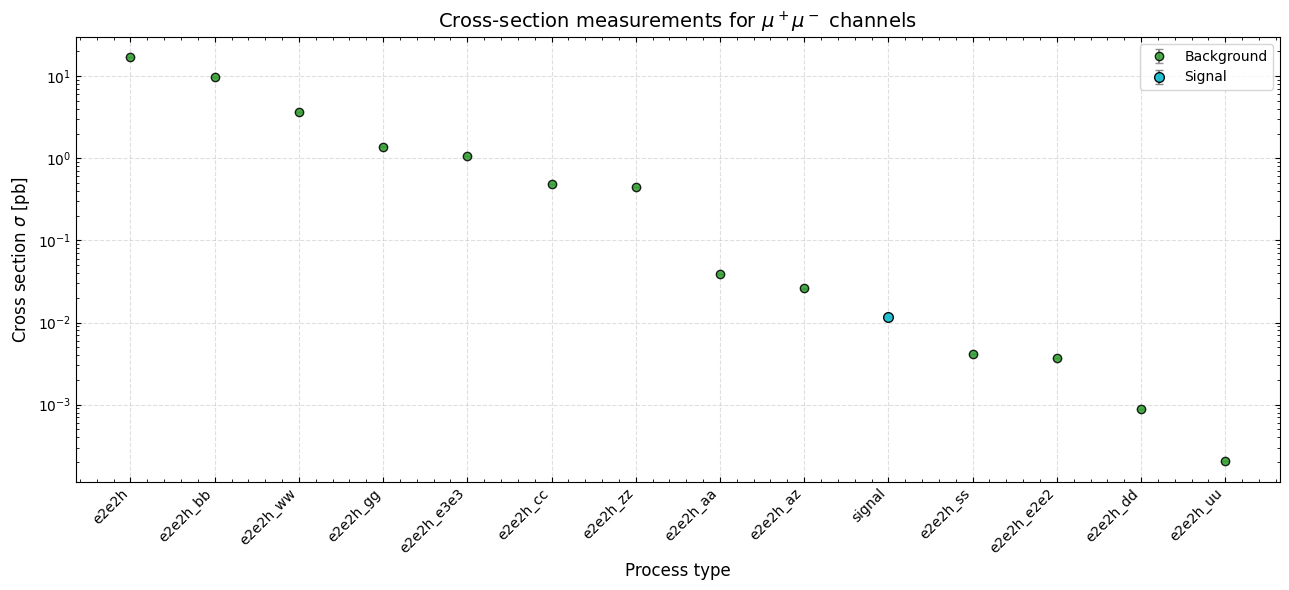

In [28]:
muon_events = muon_events.sort_values(
    by="xsect_pb",
    ascending=False
).reset_index(drop=True)
muon_events["xpos"] = range(len(muon_events))
signal_df = muon_events[muon_events["process_type"] == "signal"]
bkg_df    = muon_events[muon_events["process_type"] != "signal"]

plt.figure(figsize=(13, 6))

# Background
plt.errorbar(
    bkg_df["xpos"],
    bkg_df["xsect_pb"],
    yerr=bkg_df["xsect_error_pb"],
    fmt="o",
    color=plt.cm.tab20(0.2),
    ecolor="gray",
    capsize=3,
    markersize=6,
    markeredgecolor="k",
    alpha=0.85,
    label="Background",
)

# Signal (on top)
plt.errorbar(
    signal_df["xpos"],
    signal_df["xsect_pb"],
    yerr=signal_df["xsect_error_pb"],
    fmt="o",
    color=plt.cm.tab20(0.9),
    ecolor="gray",
    capsize=3,
    markersize=7,
    markeredgecolor="k",
    alpha=0.95,
    label="Signal",
)



# X-axis labels
plt.xticks(
    muon_events["xpos"],
    muon_events["process_type"],
    rotation=45,
    ha="right",
)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.grid(True, linestyle='--', alpha=0.4)
plt.yscale("log")
plt.title(r"Cross-section measurements for $\mu^+\mu^-$ channels", fontsize=14)
plt.xlabel(r"Process type", fontsize=12)
plt.ylabel(r"Cross section $\sigma$ [pb]", fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig("cross_section_errorbars.png", dpi=300)
plt.show()



In [13]:
selected = muon_events[['process_type', 'xsect_pb', 'xsect_error_pb']]

# Print them (or display in a notebook)
print(selected)

   process_type   xsect_pb  xsect_error_pb
0         e2e2h  16.970655    1.380000e-02
1      e2e2h_bb   9.876921    8.031600e-03
2      e2e2h_ww   3.631720    2.953200e-03
3      e2e2h_gg   1.389897    1.130220e-03
4    e2e2h_e3e3   1.064060    8.652600e-04
5      e2e2h_cc   0.490452    3.988200e-04
6      e2e2h_zz   0.444631    3.615600e-04
7      e2e2h_aa   0.038523    3.132600e-05
8      e2e2h_az   0.025965    2.111400e-05
9        signal   0.011646    0.000000e+00
10     e2e2h_ss   0.004175    3.394800e-06
11   e2e2h_e2e2   0.003700    3.008400e-06
12     e2e2h_dd   0.000882    7.176000e-07
13     e2e2h_uu   0.000204    1.656000e-07


Calculating the relative error for the cross-section
# $\frac{\sigma(\sigma_{i})}{\sigma_{i}}$

In [14]:
relative_error = muon_events["xsect_error_pb"]/muon_events["xsect_pb"]
relative_error

0     0.000813
1     0.000813
2     0.000813
3     0.000813
4     0.000813
5     0.000813
6     0.000813
7     0.000813
8     0.000813
9     0.000000
10    0.000813
11    0.000813
12    0.000813
13    0.000813
dtype: float64

Relative error for the cross-sections are almost all the same value.
Now plotting the weights of the muons producing events.

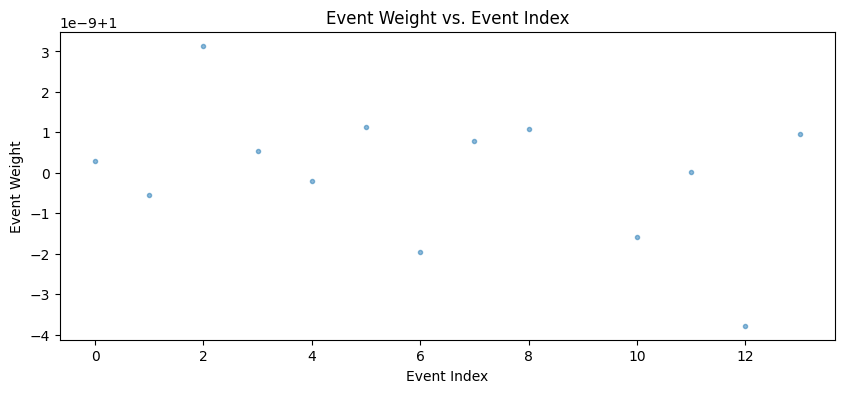

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(muon_events.index, muon_events["event_weight"], marker='.', linestyle='none', alpha=0.5)
plt.title("Event Weight vs. Event Index")
plt.xlabel("Event Index")
plt.ylabel("Event Weight")
#plt.yscale('log')          # optional, useful for wide ranges
plt.show()

All weights are equal to $1$ with $10^{-9}$ error.
The relative weight of the events can be calculated with:
# $\frac{1}{\sqrt{N}}$

In [16]:
muon_events["rel_err_weight"] = 1.0 / np.sqrt(muon_events["NbEvents"])
muon_events["rel_err_weight"]

0     0.001414
1     0.003162
2     0.001414
3     0.003162
4     0.001414
5     0.003162
6     0.001414
7     0.003162
8     0.003162
9          NaN
10    0.003162
11    0.003162
12    0.003162
13    0.003162
Name: rel_err_weight, dtype: float64

The absolute error weights are:

In [17]:
muon_events["abs_err_weight"] = muon_events["event_weight"] * muon_events["rel_err_weight"]
muon_events["abs_err_weight"]

0     0.001414
1     0.003162
2     0.001414
3     0.003162
4     0.001414
5     0.003162
6     0.001414
7     0.003162
8     0.003162
9          NaN
10    0.003162
11    0.003162
12    0.003162
13    0.003162
Name: abs_err_weight, dtype: float64

Process type of the muon producing events

In [18]:
muon_events[["process_type","pol"]]

,process_type,pol
0,e2e2h,eL.pR
1,e2e2h_bb,eL.pR
2,e2e2h_ww,eL.pR
3,e2e2h_gg,eL.pR
4,e2e2h_e3e3,eL.pR
5,e2e2h_cc,eL.pR
6,e2e2h_zz,eL.pR
7,e2e2h_aa,eL.pR
8,e2e2h_az,eL.pR
9,signal,eL.pR


In [19]:
def filter_elpr_from_txt(
    txt_file: str | Path,
    file_ext: str = ".slcio",
) -> list[str]:
    """
    Read a txt file containing paths and return only slcio files
    with 'eL.pR' in the filename.
    """
    txt_file = Path(txt_file)

    selected_files = []

    with txt_file.open() as f:
        for line in f:
            path = line.strip()

            # skip empty lines
            if not path:
                continue

            # keep only slcio files
            if not path.endswith(file_ext):
                continue

            # polarization filter
            if "eL.pR" not in Path(path).name:
                continue

            selected_files.append(path)

    return selected_files

def write_file_list(files: list[str], output_txt: str | Path):
    with open(output_txt, "w") as f:
        for path in files:
            f.write(path + "\n")

PROCESS_RE = re.compile(r"\.(I\d{6})\.")

def group_files_by_process(
    txt_file: str | Path,
    polarization: str = "eL.pR",
    file_ext: str = ".slcio",
) -> dict[str, list[str]]:
    """
    Read a txt file with paths and group slcio files by process ID (I######).

    Returns
    -------
    dict
        { "I500153": [file1, file2, ...], ... }
    """
    groups = defaultdict(list)

    with open(txt_file) as f:
        for line in f:
            path = line.strip()
            if not path:
                continue

            # basic filters
            if not path.endswith(file_ext):
                continue
            if polarization not in Path(path).name:
                continue

            # extract process ID
            match = PROCESS_RE.search(path)
            if not match:
                continue  # skip malformed filenames

            process_id = match.group(1)
            groups[process_id].append(path)

    return dict(groups)

In [20]:
files_elpr = filter_elpr_from_txt("all_paths.txt")

write_file_list(files_elpr, "files_eL_pR.txt")

print(f"Found {len(files_elpr)} eL.pR events")

groups = group_files_by_process("all_paths.txt", polarization="eL.pR")

clean_dict = {int(k.lstrip('I')): v for k, v in groups.items()}

Found 75751 eL.pR events


The pid has the format "IXXXXXX" so doing pid[1:] is equal to having "XXXXXX"

In [21]:
n_files_map = {pid[1:]: len(files) for pid, files in groups.items()}
# Convert dict → Series (index = process_id)
mapping_series = pd.Series(n_files_map, name='n_files')

# Make sure the index types line up
mapping_series.index = mapping_series.index.astype(filtered_df['process_id'].dtype)

# Join on the process_id column
filtered_df = filtered_df.set_index('process_id').join(mapping_series).reset_index()
filtered_df.head()

,process_id,ProducedRate,n_prod,n_gen,process_type,pol,NbEvents,int.lumi(1/fb),Done %,ElogID(s),ProdIDs of DST and REC files,xsect_pb,xsect_error_pb,int_lumi_fb,energy_GeV,source_url,event_weight,n_files
0,402001,99.96%,6997400,7000000,e1e1h,eL.pR,500000,28294,100.0,347,"DST=15089,15090;REC=15089",17.671491,0.0228,28294.16040,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3410,1.000000,66
1,402003,99.96%,6997400,7000000,e2e2h,eL.pR,500000,29462,100.0,347,"DST=15089,15090;REC=15089",16.970655,0.0138,29462.62240,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3413,1.000000,64
2,402005,99.96%,6997400,7000000,e3e3h,eL.pR,500000,29514,100.0,347,"DST=15089,15090;REC=15089",16.940726,0.0206,29514.67370,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3415,1.000000,65
3,402007,99.96%,6997400,7000000,n1n1h,eL.pR,499600,8278,99.9,347,"DST=15089,15090;REC=15089",60.350892,0.0620,8284.88169,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3417,1.000801,62
4,402009,99.96%,6997400,7000000,n23n23h,eL.pR,500000,7450,100.0,348,"DST=15095,15096;REC=15095",67.110727,0.0634,7450.37377,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3419,1.000000,62


In [22]:
# Assume df is your existing DataFrame
# -------------------------------------------------
# 1️⃣  Does the column contain any NaN values?
has_nan = filtered_df['n_files'].isnull().any()          # True / False
nan_count = filtered_df['n_files'].isnull().sum()       # How many NaNs

# 2️⃣  Does the column contain any zeros?
has_zero = (filtered_df['n_files'] == 0).any()           # True / False
zero_count = (filtered_df['n_files'] == 0).sum()        # How many zeros

# 3️⃣  Summary of both issues together
summary = {
    'nan_present' : has_nan,
    'nan_rows'    : nan_count,
    'zero_present': has_zero,
    'zero_rows'   : zero_count
}
print(summary)

{'nan_present': False, 'nan_rows': 0, 'zero_present': False, 'zero_rows': 0}


In [23]:
new_df = filtered_df[["process_id","n_files"]].copy()

# Add the File list into the dataframe
new_df['file_list'] = new_df['process_id'].map(clean_dict)
# Transform into a json for better import in the Key4Hep code
new_df['file_list'] = new_df['file_list'].apply(json.dumps)
new_df.to_csv("process_id.csv",index=False)
print(new_df["n_files"].sum())
new_df

75751


,process_id,n_files,file_list
0,402001,66,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."
1,402003,64,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."
2,402005,65,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."
3,402007,62,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."
4,402009,62,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."
...,...,...,...
118,410002,50,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."
119,410005,48,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."
120,410006,68,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."
121,410003,47,"[""/pnfs/desy.de/ilc/prod/ilc/mc-2020/ild/dst-m..."


In [24]:
mask = new_df["process_id"] == 402001
n_files = new_df.loc[mask, "n_files"].iloc[0]
print(n_files)
slcio_files = new_df.loc[mask, "file_list"].iloc[0]
size = len(slcio_files)

66


In [25]:
# 1️⃣  Boolean mask – True where the value is null
null_mask = new_df['file_list'].isnull()
print(null_mask.head())

# 2️⃣  Count how many nulls there are
null_count = null_mask.sum()
print(f"Number of null entries in file_list: {null_count}")

# 3️⃣  Does the column contain *any* nulls?
has_null = null_mask.any()
print(f"Column has nulls? {has_null}")

# 4️⃣  Show the rows that contain nulls (useful for inspection / fixing)
rows_with_null = new_df[null_mask]
print(rows_with_null)

0    False
1    False
2    False
3    False
4    False
Name: file_list, dtype: bool
Number of null entries in file_list: 0
Column has nulls? False
Empty DataFrame
Columns: [process_id, n_files, file_list]
Index: []


In [26]:
columns = ['process_id', 'process_type',
        'xsect_pb', 'xsect_error_pb', 'n_files']
final_df = filtered_df[columns].copy()

import numpy as np

def format_sci_pm(x, dx, sig_x=5, sig_dx=5):
    """
    Format a value `x` with its symmetric uncertainty `dx` as

        (x ± dx) × 10ⁿ

    where `n` is the integer exponent that brings `x` into the range
    [1, 10).  If the exponent happens to be 0, the trailing
    “× 10⁰” is suppressed so the output looks like a simple
    "(x ± dx)".

    Parameters
    ----------
    x : float
        Central value.
    dx : float
        Symmetric uncertainty (must be ≥ 0).
    sig_x : int, optional
        Number of significant figures to keep for the mantissa of `x`
        (default = 5).
    sig_dx : int, optional
        Number of significant figures to keep for the mantissa of `dx`
        (default = 5).

    Returns
    -------
    str
        LaTeX‑ready string, e.g. ``r"$(1.23 \pm 0.04) \times 10^{3}$"``
        or ``r"$(0.987 \pm 0.012)$"`` when the exponent is zero.
    """
    # Zero is a special case – no scientific notation needed.
    if x == 0:
        return r"$0$"

    # -----------------------------------------------------------------
    # 1️⃣  Determine the exponent that puts |x| in [1, 10)
    # -----------------------------------------------------------------
    exp = int(np.floor(np.log10(abs(x))))          # integer exponent

    # -----------------------------------------------------------------
    # 2️⃣  Scale both central value and uncertainty to that exponent
    # -----------------------------------------------------------------
    x_scaled  = x  / 10**exp
    dx_scaled = dx / 10**exp

    # -----------------------------------------------------------------
    # 3️⃣  Round the mantissas to the requested number of sig‑figs.
    #    We round to (sig‑1) decimal places because the leading digit
    #    is already counted as one significant figure.
    # -----------------------------------------------------------------
    x_fmt  = round(x_scaled,  sig_x  - 1)
    dx_fmt = round(dx_scaled, sig_dx - 1)

    # -----------------------------------------------------------------
    # 4️⃣  Build the LaTeX string.
    #    If the exponent is zero we drop the “× 10⁰” part entirely.
    # -----------------------------------------------------------------
    if exp == 0:
        return rf"${x_fmt} \pm {dx_fmt}$"
    else:
        return rf"$({x_fmt} \pm {dx_fmt}) \times 10^{{{exp}}}$"

final_df[r"$\sigma$ [pb]"] = final_df.apply(
    lambda row: format_sci_pm(
        row["xsect_pb"],
        row["xsect_error_pb"],
    ),
    axis=1,
)

final_df = final_df.drop(columns=["xsect_pb", "xsect_error_pb"])


final_df["process_type"] = final_df["process_type"].map(
    lambda x: r"\texttt{" + x.replace("_", r"\_") + "}"
)
latex_math_cols = [
    "process_id",
    "n_files",
]

for col in latex_math_cols:
    final_df[col] = final_df[col].map(lambda x: rf"${x}$")


# Desired order
new_order = ['process_id', 'process_type', r"$\sigma$ [pb]", "n_files"]   # any permutation you like
final_df = final_df[new_order] 

final_df = final_df.rename(columns={
    'process_id': "Process ID",
    'process_type': "Process Type",
    "n_files": "Number of Files"
})


final_df

,Process ID,Process Type,$\sigma$ [pb],Number of Files
0,$402001$,\texttt{e1e1h},$(1.7671 \pm 0.0023) \times 10^{1}$,$66$
1,$402003$,\texttt{e2e2h},$(1.6971 \pm 0.0014) \times 10^{1}$,$64$
2,$402005$,\texttt{e3e3h},$(1.6941 \pm 0.0021) \times 10^{1}$,$65$
3,$402007$,\texttt{n1n1h},$(6.0351 \pm 0.0062) \times 10^{1}$,$62$
4,$402009$,\texttt{n23n23h},$(6.7111 \pm 0.0063) \times 10^{1}$,$62$
...,...,...,...,...
118,$410002$,\texttt{n23n23h\_cc},$1.9395 \pm 0.0018$,$50$
119,$410005$,\texttt{n23n23h\_dd},$(3.4898 \pm 0.0033) \times 10^{-3}$,$48$
120,$410006$,\texttt{n23n23h\_gg},$5.4964 \pm 0.0052$,$68$
121,$410003$,\texttt{n23n23h\_ss},$(1.6509 \pm 0.0016) \times 10^{-2}$,$47$


In [27]:
latex = final_df.to_latex(
    index=False,
    escape=False,
    longtable=True,
    caption="Summary of simulated processes, production IDs, and cross sections used in this analysis.",
    label="tab:process_summary",
)

print(latex)

\begin{longtable}{llll}
\caption{Summary of simulated processes, production IDs, and cross sections used in this analysis.} \label{tab:process_summary} \\
\toprule
Process ID & Process Type & $\sigma$ [pb] & Number of Files \\
\midrule
\endfirsthead
\caption[]{Summary of simulated processes, production IDs, and cross sections used in this analysis.} \\
\toprule
Process ID & Process Type & $\sigma$ [pb] & Number of Files \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
$402001$ & \texttt{e1e1h} & $(1.7671 \pm 0.0023) \times 10^{1}$ & $66$ \\
$402003$ & \texttt{e2e2h} & $(1.6971 \pm 0.0014) \times 10^{1}$ & $64$ \\
$402005$ & \texttt{e3e3h} & $(1.6941 \pm 0.0021) \times 10^{1}$ & $65$ \\
$402007$ & \texttt{n1n1h} & $(6.0351 \pm 0.0062) \times 10^{1}$ & $62$ \\
$402009$ & \texttt{n23n23h} & $(6.7111 \pm 0.0063) \times 10^{1}$ & $62$ \\
$402011$ & \texttt{qqh} & $(3.4303 \pm 0.0044) \times 10^{2}$ & $143$ \\
$402106$ & \